# Ensemble learning: when many are better that the one

In this notebook, we will go in depth into algorithms which combine several
simple learners (e.g. decision tree, linear model, etc.). We will
see that combining simple learners will result in a more powerful and robust
learner.
We will focus on two families of ensemble methods:

* ensemble using bootstrap (e.g. bagging and random-forest);
* ensemble using boosting (e.g. adaptive boosting and gradient-boosting
  decision tree).

## Benefit of ensemble method at a first glance

In this section, we will give a quick demonstration on the power of combining
several learners instead of fine-tuning a single learner.

We will start by loading the "California Housing" dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame
X, y = california_housing.data, california_housing.target

In this dataset, we want to predict the median house value in some district
in California based on demographic and geographic data.

In [2]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We start by learning a single decision tree regressor. As we previously
presented in the "tree in depth" notebook, this learner needs to be tuned to
overcome over- or under-fitting. Indeed, the default parameters will not
necessarily lead to an optimal decision tree. Instead of using the default
value, we should search via cross-validation the optimal value of the
important parameters such as `max_depth`, `min_samples_split`, or
`min_samples_leaf`.

We recall that we need to tune these parameters, as decision trees
tend to overfit the training data if we grow deep trees, but there are no
rules on how to limit the parameters. Thus, not making a search could lead us
to have an underfitted model.

First, let's keep a set of data to test our final model.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0,
)

We will first make a grid-search to fine-tune the parameters that we
mentioned earlier.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    "max_depth": [3, 5, 8, None],
    "min_samples_split": [2, 10, 30, 50],
    "min_samples_leaf": [0.01, 0.05, 0.1, 1],
}
cv = 3
tree = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
)

tree.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8, None],
                         'min_samples_leaf': [0.01, 0.05, 0.1, 1],
                         'min_samples_split': [2, 10, 30, 50]})

We can create a dataframe storing the important information collected during
the tuning of the parameters and investigate the results.

In [5]:
import pandas as pd

cv_results = pd.DataFrame(tree.cv_results_)
interesting_columns = [
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf",
    "mean_test_score",
    "rank_test_score",
    "mean_fit_time",
]
cv_results = cv_results[interesting_columns].sort_values(by="rank_test_score")
cv_results

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,rank_test_score,mean_fit_time
63,None,50,1,0.690531,1,0.079753
62,None,30,1,0.679867,2,0.084119
47,8,50,1,0.678336,3,0.058852
46,8,30,1,0.676595,4,0.059032
45,8,10,1,0.674313,5,0.059225
...,...,...,...,...,...,...
41,8,10,0.1,0.501931,49,0.027289
10,3,30,0.1,0.486399,61,0.024279
8,3,2,0.1,0.486399,61,0.024918
9,3,10,0.1,0.486399,61,0.024081


From theses results, we can see that the best parameters is the combination
where the depth of the tree is not limited and the minimum number of samples
to create a leaf is also equal to 1 (the default values) and the
minimum number of samples to make a split of 50 (much higher than the default
value.

It is interesting to look at the total amount of time it took to fit all
these different models. In addition, we can check the performance of the
optimal decision tree on the left-out testing data.

In [6]:
total_fitting_time = (cv_results["mean_fit_time"] * cv).sum()
print(
    f"Required training time of the GridSearchCV: "
    f"{total_fitting_time:.2f} seconds"
)
print(
    f"Best R2 score of a single tree: {tree.best_score_:.3f}"
)

Required training time of the GridSearchCV: 7.56 seconds
Best R2 score of a single tree: 0.691


Hence, we have a model that has an $R^2$ score below 0.7. The amount of time
to find the best learner depends on the number of folds used during the
cross-validation in the grid-search multiplied by the number of parameters.
Therefore, the computational cost is quite high.

Now we will use an ensemble method called bagging. More details about this
method will be discussed in the next section. In short, this method will use
a base regressor (i.e. decision tree regressors) and will train several of
them on a slightly modified version of the training set. Then, the
predictions of all these base regressors will be combined by averaging.

Here, we will use 50 decision trees and check the fitting time as well as
the performance on the left-out testing data. It is important to note that
we are not going to tune any parameter of the decision tree.

In [7]:
from time import time
from sklearn.ensemble import BaggingRegressor

base_estimator = DecisionTreeRegressor(random_state=0)
bagging_regressor = BaggingRegressor(
    base_estimator=base_estimator, n_estimators=50, random_state=0,
)

start_fitting_time = time()
bagging_regressor.fit(X_train, y_train)
elapsed_fitting_time = time() - start_fitting_time

print(f"Elapsed fitting time: {elapsed_fitting_time:.2f} seconds")
print(f"R2 score: {bagging_regressor.score(X_test, y_test):.3f}")

Elapsed fitting time: 5.56 seconds
R2 score: 0.792


We can see that the computation time is much shorter for training the full
ensemble than for the parameter search of a single tree. In addition, the
score is significantly improved with a $R^2$ close to 0.8. Furthermore, note
that this result is obtained before any parameter tuning. This shows the
motivation behind the use of an ensemble learner: it gives a relatively good
baseline with decent performance without any parameter tuning.

Now, we will discuss in detail two ensemble families: bagging and
boosting.

## Bagging

Bagging stands for Bootstrap AGGregatING. It uses bootstrap samples
to learn several models. At predict time, the predictions of each learner
are aggregated to give the final predictions.

Let's define a simple dataset (which we have used before in a previous
notebook).

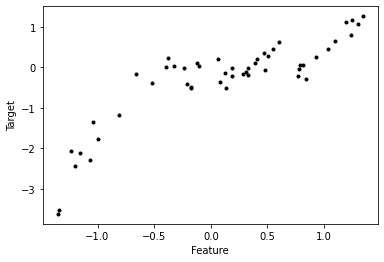

In [8]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)


def generate_data(n_samples=50, sorted=False):
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise
    if sorted:
        sorted_idx = np.argsort(x)
        x, y = x[sorted_idx], y[sorted_idx]
    return x, y


x, y = generate_data(n_samples=50)

plt.scatter(x, y,  color='k', s=9)
plt.xlabel("Feature")
_ = plt.ylabel("Target")

The link between our feature and the target to predict is non-linear.
However, a decision tree is capable of fitting such data

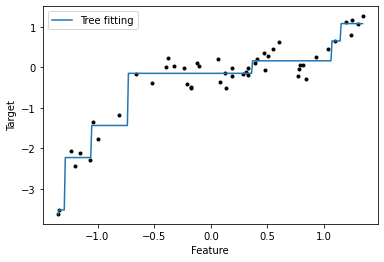

In [9]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(x.reshape(-1, 1), y)

grid = np.linspace(np.min(x), np.max(x), num=300)
y_pred = tree.predict(grid.reshape(-1, 1))

plt.scatter(x, y, color="k", s=9)
plt.plot(grid, y_pred, label="Tree fitting")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.legend()

Let's see how we can use bootstraping to learn several trees.

### Bootstrap sample

A bootstrap sample corresponds to a resampling, with replacement, of the
original dataset, a sample that is the same size as the
original dataset. Thus, the bootstrap sample will contain some
data points several times while some of the original data points will
not be present.

We will create a function that given `x` and `y` will return a bootstrap
sample `x_bootstrap` and `y_bootstrap`.

In [10]:
def bootstrap_sample(x, y):
    bootstrap_indices = rng.choice(
        np.arange(y.shape[0]), size=y.shape[0], replace=True,
    )
    x_bootstrap_sample = x[bootstrap_indices]
    y_bootstrap_sample = y[bootstrap_indices]
    return x_bootstrap_sample, y_bootstrap_sample

We will generate 3 bootstrap samples and qualitatively check the difference
with the original dataset.

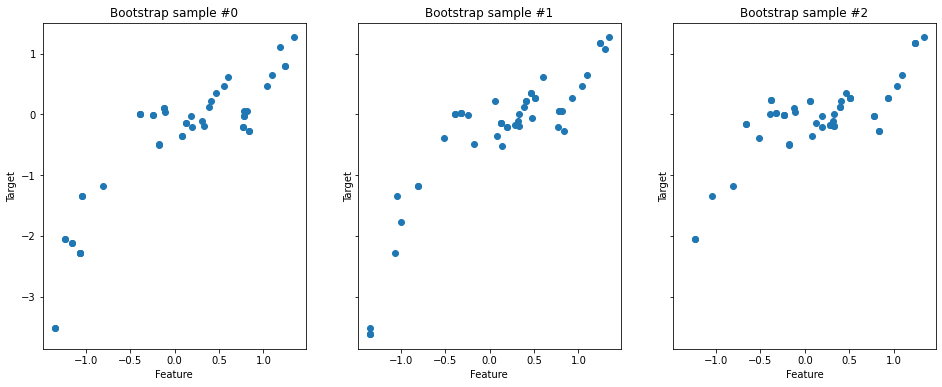

In [11]:
n_bootstrap = 3
_, axs = plt.subplots(
    ncols=n_bootstrap, figsize=(16, 6), sharex=True, sharey=True
)

for idx, (ax, _) in enumerate(zip(axs, range(n_bootstrap))):
    x_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(x, y)
    ax.scatter(
        x_bootstrap_sample, y_bootstrap_sample,
    )
    ax.set_title(f"Bootstrap sample #{idx}")
    ax.set_ylabel("Target")
    ax.set_xlabel("Feature")

We observe that the 3 generated bootstrap samples are all different. To
confirm this intuition, we can check the number of unique samples in the
bootstrap samples.

In [12]:
# we need to generate a larger set to have a good estimate
x_huge, y_huge = generate_data(n_samples=10000)
x_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(x_huge, y_huge)

print(
    f"Percentage of samples present in the original dataset: "
    f"{np.unique(x_bootstrap_sample).size / x_bootstrap_sample.size * 100:.1f}"
    f"%"
)

Percentage of samples present in the original dataset: 63.2%


Theoretically, 63.2% of the original data points of the original dataset will
be present in the bootstrap sample. The other 36.8% are just repeated
samples.

So, we are able to generate many datasets, all slightly different. Now, we
can fit a decision tree to each of these datasets and each decision
tree shall be slightly different as well.

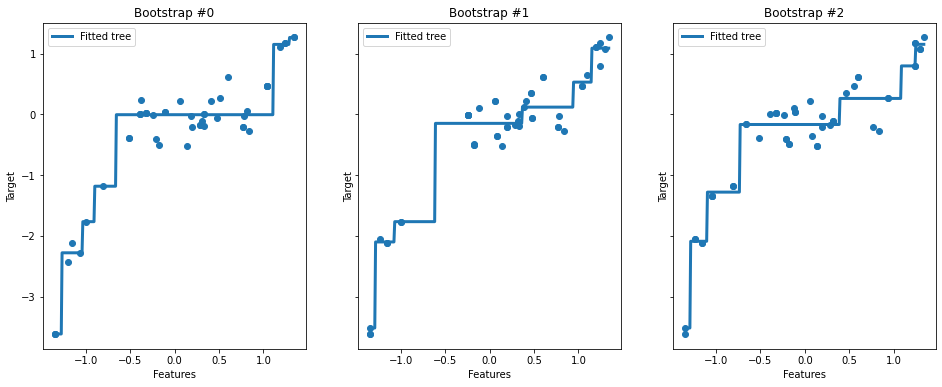

In [13]:
_, axs = plt.subplots(
    ncols=n_bootstrap, figsize=(16, 6), sharex=True, sharey=True,
)

forest = []
for idx, (ax, _) in enumerate(zip(axs, range(n_bootstrap))):
    x_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(x, y)
    ax.scatter(x_bootstrap_sample, y_bootstrap_sample)

    forest.append(
        DecisionTreeRegressor(max_depth=3, random_state=0).fit(
            x_bootstrap_sample.reshape(-1, 1), y_bootstrap_sample
        )
    )

    grid = np.linspace(np.min(x), np.max(x), num=300)
    y_pred = forest[-1].predict(grid.reshape(-1, 1))
    ax.plot(grid, y_pred, linewidth=3, label="Fitted tree")

    ax.legend()
    ax.set_ylabel("Target")
    ax.set_xlabel("Features")
    ax.set_title(f"Bootstrap #{idx}")

We can plot these decision functions on the same plot to see the difference.

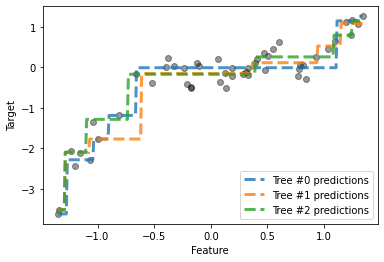

In [14]:
_, ax = plt.subplots()
ax.scatter(x, y, color="k", alpha=0.4)
y_pred_forest = []
for tree_idx, tree in enumerate(forest):
    y_pred = tree.predict(grid.reshape(-1, 1))
    ax.plot(
        grid,
        y_pred,
        "--",
        label=f"Tree #{tree_idx} predictions",
        linewidth=3,
        alpha=0.8,
    )
    y_pred_forest.append(y_pred)

plt.xlabel("Feature")
plt.ylabel("Target")
_ = plt.legend()

### Aggregating

Once our trees are fitted and we are able to get predictions for each of
them, we also need to combine them. In regression, the most straightforward
approach is to average the different predictions from all learners. We can
plot the averaged predictions from the previous example.

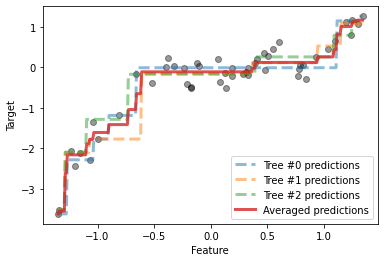

In [15]:
_, ax = plt.subplots()
ax.scatter(x, y, color="k", alpha=0.4)
y_pred_forest = []
for tree_idx, tree in enumerate(forest):
    y_pred = tree.predict(grid.reshape(-1, 1))
    ax.plot(
        grid,
        y_pred,
        "--",
        label=f"Tree #{tree_idx} predictions",
        linewidth=3,
        alpha=0.5,
    )
    y_pred_forest.append(y_pred)

# Averaging the predictions
y_pred_forest = np.mean(y_pred_forest, axis=0)
ax.plot(
    grid,
    y_pred_forest,
    "-",
    label="Averaged predictions",
    linewidth=3,
    alpha=0.8,
)

plt.xlabel("Feature")
plt.ylabel("Target")
_ = plt.legend()

The unbroken red line shows the averaged predictions, which would be the
final preditions given by our 'bag' of decision tree regressors.

## Random forest

A popular machine-learning algorithm is the random forest. A Random forest
is a modification of the bagging algorithm. In bagging, any classifier or
regressor can be used. In a random forest, the base classifier or regressor
must be a decision tree. In our previous example, we used a decision
tree but we could have used a linear model as the regressor for our
bagging algorithm.

In addition, random forest is different from bagging when used with
classifiers: when searching for the best split, only a subset of the original
features are used. By default, this subset of feature is equal to the square
root of the total number of features. In regression, the total number of
available features will be used.

We will illustrate the usage of a random forest and compare it with the
bagging regressor on the "California housing" dataset.

In [16]:
X, y = california_housing.data, california_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(
    n_estimators=100, random_state=0, n_jobs=-1
)
bagging = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(random_state=0),
    n_estimators=100,
    n_jobs=-1,
)

random_forest.fit(X_train, y_train)
bagging.fit(X_train, y_train)

print(
    f"Performance of random forest: {random_forest.score(X_test, y_test):.3f}"
)
print(f"Performance of bagging: {bagging.score(X_test, y_test):.3f}")

Performance of random forest: 0.794


Performance of bagging: 0.792


Notice that we don't need to provide a `base_estimator` parameter to
`RandomForestRegressor`, it is always a tree classifier. Also note that the
scores are almost identical. This is because our
problem is a regression problem and therefore, the number of features used
in random forest and bagging is the same.

For classification problems, we would need to pass a tree model instance
with the parameter `max_features="sqrt"` to `BaggingRegressor` if we wanted
it to have the same behaviour as the random forest classifier.

### Classifiers details

Up to now, we have only focused on regression problems. There is a little
difference between regression and classification.

First, the `base_estimator` should be chosen in line with the problem that
is solved: use a classifier with a classification problem and a regressor
with a regression problem.

Then, the aggregation method is different in regression and classification:
the averaged predictions is computed in regression while the majority class
(weighted by the probabilities) is predicted in classification.

## Summary

We saw in this section two algorithms that use bootstrap samples to create
an ensemble of classifiers or regressors. These algorithms train several
learners on different bootstrap samples. The predictions are then
aggregated. This operation can be done in a very efficient manner since the
training of each learner can be done in parallel.

## Boosting

We recall that bagging builds an ensemble in a parallel manner: each learner
is trained independently from each other. The idea behind boosting is
different. The ensemble is a sequence of learners where the
`Nth` learner requires all previous learners, from 1 to `N-1`.

Intuitively, bagging adds learners to the ensemble to correct the
mistakes of the previous learners. We will start with an
algorithm named Adaptive Boosting (AdaBoost) to get some intuition about the
main ideas behind boosting.

### Adaptive Boosting (AdaBoost)

We will first focus on AdaBoost, which we will use for a classification
problem.
We will load the "penguin" dataset used in the "tree in depth" notebook.
We will predict penguin species from the features culmen length and depth.

In [17]:
data = pd.read_csv("../datasets/penguins.csv")

# select the features of interest
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data = data[culmen_columns + [target_column]]
data[target_column] = data[target_column].str.split().str[0]
data = data.dropna()

X, y = data[culmen_columns], data[target_column]

In addition, we are also using on the function used the previous
"tree in depth" notebook
to plot the decision function of the tree.

In [18]:
import seaborn as sns


def plot_decision_function(X, y, clf, sample_weight=None, fit=True, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    if fit:
        clf.fit(X, y, sample_weight=sample_weight)

    # create a grid to evaluate all possible samples
    plot_step = 0.02
    feature_0_min, feature_0_max = (
        X.iloc[:, 0].min() - 1,
        X.iloc[:, 0].max() + 1,
    )
    feature_1_min, feature_1_max = (
        X.iloc[:, 1].min() - 1,
        X.iloc[:, 1].max() + 1,
    )
    xx, yy = np.meshgrid(
        np.arange(feature_0_min, feature_0_max, plot_step),
        np.arange(feature_1_min, feature_1_max, plot_step),
    )

    # compute the associated prediction
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4)
    sns.scatterplot(
        data=pd.concat([X, y], axis=1),
        x=X.columns[0],
        y=X.columns[1],
        hue=y.name,
        ax=ax,
    )

We will purposely train a shallow decision tree. Since the tree is shallow,
it is unlikely to overfit and some of the training examples will even be
misclassified on the training set.

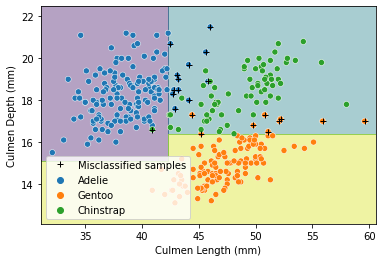

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=0)

_, ax = plt.subplots()
plot_decision_function(X, y, tree, ax=ax)

# find the misclassified samples
y_pred = tree.predict(X)
misclassified_samples_idx = np.flatnonzero(y != y_pred)

ax.plot(
    X.iloc[misclassified_samples_idx, 0],
    X.iloc[misclassified_samples_idx, 1],
    "+k",
    label="Misclassified samples",
)
ax.legend()

We observe that several samples have been misclassified by the
classifier.

We mentioned that boosting relies on creating a new classifier which tries to
correct these misclassifications. In scikit-learn, learners support a
parameter `sample_weight` which forces the learner to pay more attention to
samples with higher weights, during the training.

This parameter is set when calling
`classifier.fit(X, y, sample_weight=weights)`.
We will use this trick to create a new classifier by 'discarding' all
correctly classified samples and only considering the misclassified samples.
Thus, mosclassified samples will be assigned a weight of 1 while well
classified samples will assigned to a weight of 0.

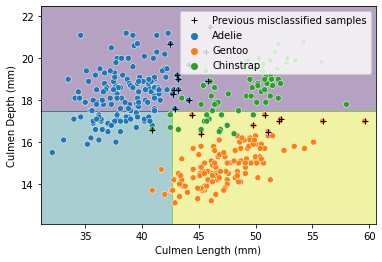

In [20]:
sample_weight = np.zeros_like(y, dtype=int)
sample_weight[misclassified_samples_idx] = 1

_, ax = plt.subplots()
plot_decision_function(X, y, tree, sample_weight=sample_weight, ax=ax)

ax.plot(
    X.iloc[misclassified_samples_idx, 0],
    X.iloc[misclassified_samples_idx, 1],
    "+k",
    label="Previous misclassified samples",
)
ax.legend()

We see that the decision function drastically changed. Qualitatively,
we see that the previously misclassified samples are now correctly
classified.

In [21]:
y_pred = tree.predict(X)
newly_misclassified_samples_idx = np.flatnonzero(y != y_pred)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(
    f"Number of samples previously misclassified and still misclassified: "
    f"{len(remaining_misclassified_samples_idx)}"
)

Number of samples previously misclassified and still misclassified: 0


However, we are making mistakes on previously well classified samples. Thus,
we get the intuition that we should weight the predictions of each classifier
differently, most probably by using the number of mistakes each classifier
is making.

So we could use the classification error to combine both trees.

In [22]:
ensemble_weight = [
    (y.shape[0] - len(misclassified_samples_idx)) / y.shape[0],
    (y.shape[0] - len(newly_misclassified_samples_idx)) / y.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

The first classifier was 94% accurate and the second one 69% accurate.
Therefore, when predicting a class, we should trust the first classifier
slightly more than the second one. We could use these accuracy values to
weight the predictions of each learner.

To summarize, boosting learns several classifiers, each of which will
focus more or less on specific samples of the dataset. Boosting is thus
different from bagging: here we never resample our dataset, we just assign
different weights to the original dataset.

Boosting requires some strategy to combine the learners together:

* one needs to define a way to compute the weights to be assigned
  to samples;
* one needs to assign a weight to each learner when making predictions.

Indeed, we defined a really simple scheme to assign sample weights and
learner weights. However, there are statistical theory for how these
these sample and learner weights can be optimally calculated.
FIXME: I think we should add a reference to ESL here.

We will use the AdaBoost classifier implemented in scikit-learn and
look at the underlying decision tree classifiers trained.

Weight of each classifier: [3.58351894 3.46901998 3.03303773]
Error of each classifier: [0.05263158 0.05864198 0.08787269]


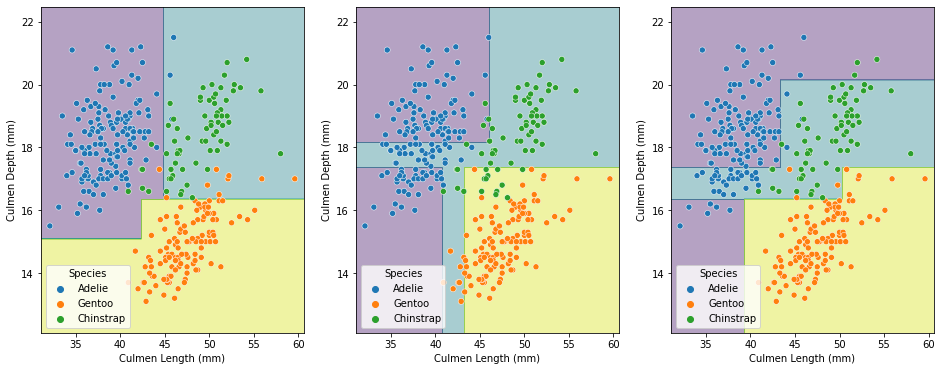

In [23]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=0),
    n_estimators=3,
    algorithm="SAMME",
    random_state=0,
)
adaboost.fit(X, y)

_, axs = plt.subplots(ncols=3, figsize=(16, 6))

for ax, tree in zip(axs, adaboost.estimators_):
    plot_decision_function(X, y, tree, fit=False, ax=ax)

print(f"Weight of each classifier: {adaboost.estimator_weights_}")
print(f"Error of each classifier: {adaboost.estimator_errors_}")

We see that AdaBoost has learnt three different classifiers each of which
focuses on different samples. Looking at the weights of each learner, we see
that the ensemble gives the highest weight to the first classifier. This
indeed makes sense when we look at the errors of each classifier. The first
classifier also has the highest classification performance.

While AdaBoost is a nice algorithm to demonsrate the internal machinery of
boosting
algorithms, it is not the most efficient machine-learning algorithm.
The most efficient algorithm based on boosting is the gradient-boosting
decision tree (GBDT) algorithm which we will discuss now.

### Gradient-boosting decision tree (GBDT)

Gradient-boosting differs from AdaBoost due to the following reason: instead
of assigning weights to specific samples, GBDT will fit a decision
tree on the residuals (hence the name "gradient") of the previous tree.
Therefore, each new added tree in the ensemble predicts the error made by the
previous learner instead of predicting the target directly.

In this section, we will provide some intuition about the way learners
are combined to give the final prediction. In this regard, let's go back
to our regression problem which is more intuitive for demonstrating the
underlying machinery.

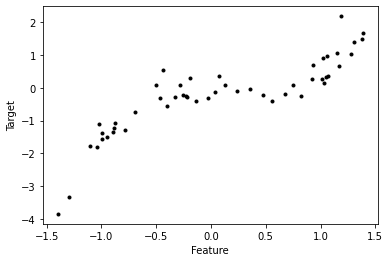

In [24]:
x, y = generate_data(sorted=True)

plt.scatter(x, y, color="k", s=9)
plt.xlabel("Feature")
_ = plt.ylabel("Target")

As we previously discussed, boosting will be based on assembling a sequence
of learners. We will start by creating a decision tree regressor. We will fix
the depth of the tree so that the resulting learner will underfit the data.

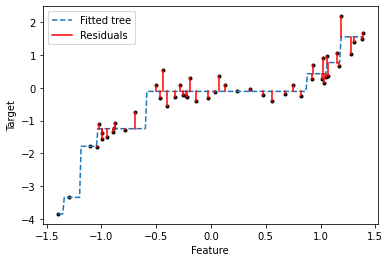

In [25]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(x.reshape(-1, 1), y)

grid = np.linspace(np.min(x), np.max(x), num=200)
y_pred_grid_raw = tree.predict(grid.reshape(-1, 1))

plt.scatter(x, y, color="k", s=9)
plt.xlabel("Feature")
plt.ylabel("Target")
line_predictions = plt.plot(grid, y_pred_grid_raw, "--")

y_pred_raw = tree.predict(x.reshape(-1, 1))
for idx in range(len(y)):
    lines_residuals = plt.plot(
        [x[idx], x[idx]], [y[idx], y_pred_raw[idx]], color="red",
    )

_ = plt.legend(
    [line_predictions[0], lines_residuals[0]], ["Fitted tree", "Residuals"]
)

Since the tree underfits the data, its accuracy is far
from perfect on the training data. We can observe this in the figure by
looking at the difference between the predictions and the ground-truth data.
We represent these errors, called "Residuals", by unbroken red lines.

Indeed, our initial tree was not expressive enough to handle the complexity
of the data, as shown by the residuals.
In a gradient-boosting algorithm, the idea is to create a second tree
which, given the same data `x`, will try to predict the residuals instead of
the target `y`. We would therefore have a tree that is able to predict the
errors made by the initial tree.

Let's train such a tree.

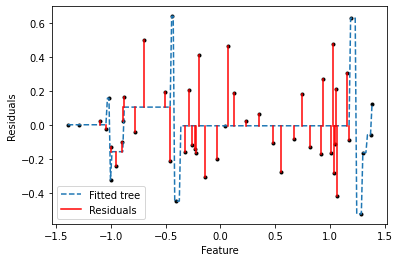

In [26]:
residuals = y - y_pred_raw

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(x.reshape(-1, 1), residuals)

y_pred_grid_residuals = tree_residuals.predict(grid.reshape(-1, 1))

plt.scatter(x, residuals, color="k", s=9)
plt.xlabel("Feature")
plt.ylabel("Residuals")
line_predictions = plt.plot(grid, y_pred_grid_residuals, "--")

y_pred_residuals = tree_residuals.predict(x.reshape(-1, 1))
for idx in range(len(y)):
    lines_residuals = plt.plot(
        [x[idx], x[idx]], [residuals[idx], y_pred_residuals[idx]], color="red",
    )

_ = plt.legend(
    [line_predictions[0], lines_residuals[0]], ["Fitted tree", "Residuals"]
)

We see that this new tree only manages to fit some of the residuals.
We will focus on the last sample in `x` and
explain how the predictions of both trees are combined.

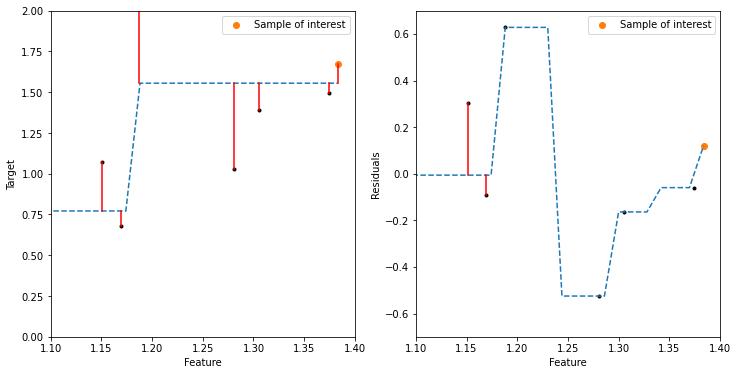

In [27]:
_, axs = plt.subplots(ncols=2, figsize=(12, 6), sharex=True)

axs[0].scatter(x, y, color="k", s=9)
axs[0].set_xlabel("Feature")
axs[0].set_ylabel("Target")
axs[0].plot(grid, y_pred_grid_raw, "--")

axs[1].scatter(x, residuals, color="k", s=9)
axs[1].set_xlabel("Feature")
axs[1].set_ylabel("Residuals")
plt.plot(grid, y_pred_grid_residuals, "--")

for idx in range(len(y)):
    axs[0].plot(
        [x[idx], x[idx]], [y[idx], y_pred_raw[idx]], color="red",
    )
    axs[1].plot(
        [x[idx], x[idx]], [residuals[idx], y_pred_residuals[idx]], color="red",
    )

axs[0].scatter(x[-1], y[-1], color="tab:orange", label="Sample of interest")
axs[1].scatter(
    x[-1], residuals[-1], color="tab:orange", label="Sample of interest"
)

axs[0].set_xlim([1.1, 1.4])
axs[1].set_xlim([1.1, 1.4])
axs[0].set_ylim([0, 2])
axs[1].set_ylim([-0.7, 0.7])
axs[0].legend()
axs[1].legend()

For our sample of interest, our initial tree is making an error (small
residual). When
fitting the second tree, the residual in this case is perfectly fitted and
predicted. We will quantitatively check this prediction using the fitted
tree. First, let's check the prediction of the initial tree and compare it
with the true value.

In [28]:
x_max = x[-1]
y_true = y[-1]

print(f"True value to predict for f(x={x_max:.3f}) = {y_true:.3f}")

y_pred_first_tree = tree.predict([[x_max]])[0]
print(
    f"Prediction of the first decision tree for x={x_max:.3f}: "
    f"y={y_pred_first_tree:.3f}"
)
print(f"Error of the tree: {y_true - y_pred_first_tree:.3f}")

True value to predict for f(x=1.384) = 1.676
Prediction of the first decision tree for x=1.384: y=1.555
Error of the tree: 0.121


As we visually observed, we have a small error. Now, we can use the second
tree to try to predict this residual.

In [29]:
print(
    f"Prediction of the residual for x={x_max:.3f}: "
    f"{tree_residuals.predict([[x_max]])[0]:.3f}"
)

Prediction of the residual for x=1.384: 0.121


We see that our second tree is capable of prediting the exact residual
(error) of our first tree. Therefore, we can predict the value of
`x` by summing the prediction of the all trees in the ensemble.

In [30]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict([[x_max]])[0]
)
print(
    f"Prediction of the first and second decision trees combined for "
    f"x={x_max:.3f}: y={y_pred_first_and_second_tree:.3f}"
)
print(f"Error of the tree: {y_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision trees combined for x=1.384: y=1.676
Error of the tree: 0.000


We chose a sample for which only two trees were enough to make the perfect
prediction. However, we saw in the previous plot that two trees were not
enough to correct the residuals of all samples. Therefore, one needs to
add several trees to the ensemble to successfully correct the error.

We will compare the performance of random-forest and gradient boosting on
the California housing dataset.

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

X, y = california_housing.data, california_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,)

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
start_time = time()
gradient_boosting.fit(X_train, y_train)
fit_time_gradient_boosting = time() - start_time

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=-1)
start_time = time()
random_forest.fit(X_train, y_train)
fit_time_random_forest = time() - start_time

print(
    f"The performance of gradient-boosting are:"
    f"{gradient_boosting.score(X_test, y_test):.3f}"
)
print(f"Fitting time took: {fit_time_gradient_boosting:.2f} seconds")

print(
    f"The performance of random-forest are:"
    f"{random_forest.score(X_test, y_test):.3f}"
)
print(f"Fitting time took: {fit_time_random_forest:.2f} seconds")

The performance of gradient-boosting are:0.804
Fitting time took: 7.34 seconds


The performance of random-forest are:0.795
Fitting time took: 11.12 seconds


In term of computation performance, the forest can be parallelized and will
benefit from the having multiple CPUs. In terms of scoring performance, both
algorithms lead to very close results.

## Parameter consideration with random forest and gradient-boosting

In the previous section, we did not discuss the parameters of random forest
and gradient-boosting. However, there are a couple of things to keep in mind
when setting these parameters.

### Random forest

The main parameter to tune with random forest is the `n_estimators`
parameter. In general, the more trees in the forest, the better the
performance will be. However, it will slow down the fitting and prediction
time. So one has to balance compute time and performance when setting the
number of estimators when putting such learner in production.

The `max_depth` parameter could also be tuned. Sometimes, there is no need
to have fully grown trees. However, be aware that with random forest, trees
are generally deep since we are seeking to overfit the learners on the
bootstrap samples because this will be mitigated by combining them.
Assembling underfitted trees (i.e. shallow trees) might also lead to an
underfitted forest.

In [32]:
param_grid = {
    "n_estimators": [10, 20, 30],
    "max_depth": [3, 5, None],
}
grid_search = GridSearchCV(
    RandomForestRegressor(n_jobs=-1), param_grid=param_grid, n_jobs=-1,
)
grid_search.fit(X_train, y_train)

columns = ["params", "mean_test_score", "rank_test_score"]
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[columns].sort_values(by="rank_test_score")

,params,mean_test_score,rank_test_score
8,"{'max_depth': None, 'n_estimators': 30}",0.794470,1
7,"{'max_depth': None, 'n_estimators': 20}",0.790711,2
6,"{'max_depth': None, 'n_estimators': 10}",0.777455,3
5,"{'max_depth': 5, 'n_estimators': 30}",0.664080,4
4,"{'max_depth': 5, 'n_estimators': 20}",0.662135,5
3,"{'max_depth': 5, 'n_estimators': 10}",0.660847,6
2,"{'max_depth': 3, 'n_estimators': 30}",0.561776,7
1,"{'max_depth': 3, 'n_estimators': 20}",0.560810,8
0,"{'max_depth': 3, 'n_estimators': 10}",0.557636,9


We can observe that in our grid-search, the largest `max_depth` together with
largest `n_estimators` led to the best performance.

### Gradient-boosting decision tree

For gradient-boosting, parameter tuning is a combination of several
parameters instead of setting one after the other each parameter. The
important parameters are `n_estimators`, `max_depth`, and `learning_rate`.

Let's first discuss the `max_depth` parameter. We saw in the section on
gradient-boosting that the algorithm fits the error of the previous tree
in the ensemble. Thus, fitting fully grown trees will be detrimental. Indeed,
the first tree of the ensemble would perfectly fit (overfit) the data and
thus no subsequent tree would be required, since there would be no residuals.
Therefore, the tree used in gradient-boosting should have a low depth,
typically between 3 to 8 levels.

With this consideration in mind, the deeper the trees, the faster the
residuals will be corrected and less learners are required. So `n_estimators`
should be increased if `max_depth` is lower.

Finally, we have overlooked the impact of the `learning_rate` parameter up
till now. When
fitting the residuals one could choose if the tree should try to correct all
possible errors or only a fraction of them. The learning-rate allows you to
control this behaviour. A small learning-rate value would only correct the
residuals of very few samples. If a large learning-rate is set (e.g., 1),
we would fit the residuals of all samples. So, with a very low
learning-rate, we will need more estimators to correct the overall error.
However, a too large learning-rate tends to obtain an overfitted ensemble,
similar to having a too large tree depth.

In [33]:
param_grid = {
    "n_estimators": [10, 30, 50],
    "max_depth": [3, 5, None],
    "learning_rate": [0.1, 1],
}
grid_search = GridSearchCV(
    GradientBoostingRegressor(), param_grid=param_grid, n_jobs=-1,
)
grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[columns].sort_values(by="rank_test_score")

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.798289,1
11,"{'learning_rate': 1, 'max_depth': 3, 'n_estima...",0.784097,2
10,"{'learning_rate': 1, 'max_depth': 3, 'n_estima...",0.780980,3
4,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.767519,4
2,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.754046,5
12,"{'learning_rate': 1, 'max_depth': 5, 'n_estima...",0.752127,6
13,"{'learning_rate': 1, 'max_depth': 5, 'n_estima...",0.747502,7
9,"{'learning_rate': 1, 'max_depth': 3, 'n_estima...",0.744140,8
14,"{'learning_rate': 1, 'max_depth': 5, 'n_estima...",0.732779,9
1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.706039,10


## Accelerating gradient-boosting

We previously mentioned that random-forest is an efficient algorithm since
each tree of the ensemble can be fitted at the same time independently.
Therefore, the algorithm scales efficiently with both the number of CPUs and
the number of samples.

In gradient-boosting, the algorithm is a sequential algorithm. It requires
the `N-1` trees to have been fit to be able to fit the tree at stage `N`.
Therefore, the algorithm is
quite computationally expensive. The most expensive part in this algorithm is
the search for the best split in the tree which is a brute-force
approach: all possible split are evaluated and the best one is picked. We
explained this process in the notebook "tree in depth", which
you can refer to.

To accelerate the gradient-boosting algorithm, one could reduce the number of
splits to be evaluated. As a consequence, the performance of such a
tree would be reduced. However, since we are combining several trees in a
gradient-boosting, we can add more estimators to overcome
this issue.

This algorithm is called `HistGradientBoostingClassifier` and
`HistGradientBoostingRegressor`. Each feature in the dataset `X` is first
binned by computing histograms which are later used to evaluate the potential
splits. The number
of splits to evaluate is then much smaller. This algorithm becomes much more
efficient than gradient bossting when the dataset has 10,000+ samples.

Below we will give an example of a large dataset and we can compare
computation time with the earlier experiment in the previous section.

In [34]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

histogram_gradient_boosting = HistGradientBoostingRegressor(
    max_iter=200, random_state=0,
)
start_time = time()
histogram_gradient_boosting.fit(X_train, y_train)
fit_time_histogram_gradient_boosting = time() - start_time

print(
    f"The performance of histogram gradient-boosting are:"
    f"{histogram_gradient_boosting.score(X_test, y_test):.3f}"
)
print(f"Fitting time took: {fit_time_histogram_gradient_boosting:.2f} seconds")

The performance of histogram gradient-boosting are:0.845
Fitting time took: 1.27 seconds


The histogram gradient-boosting is the best algorithm in terms of score.
It will also scale when the number of samples increases, while the normal
gradient-boosting will not.

## Wrap-up

So in this notebook we discussed ensemble learners which are a type of
learner that combines simpler learners together. We saw two strategies:
one based on bootstrap samples allowing learners to be fit in a parallel
manner and the other called boosting which fit learners in a sequential
manner.

From these two families, we mainly focused on giving intuitions regarding the
internal machinery of the random forest and gradient-boosting algorithms
which are state-of-the-art methods.